## Extended Isolation Forest Benchmark

H2O cloud is inicialize before every run and shutdown after every run. Algorithm is firstly tested on Training performance and after on Evaluation performance.

* N = number of rows
* P = number of collumns
* sample_size = how many rows will be used to built a tree
* max_depth = only for IF, how big is the depth of the tree, in EIF is always set on math.ceil(math.log(sample_size, 2)) and max_depth is always depends on sample_size in benchmark

Computer parameters:
 * Lenovo ThinkPad P53,
 * MS Windows 10 Pro x64,
 * Intel Core i7-9850H CPU @ 2.60GHz,
 * 6 cores and 12 threads,
 * 96.0 GB RAM.

In [1]:
import sys
sys.path.append("D:/skola/dip/h2o-3/h2o-py/build/main") # path to h2o build

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import time
import math
import h2o
from h2o.estimators import H2OIsolationForestEstimator
from h2o.estimators import H2OExtendedIsolationForestEstimator
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_blobs

versionFromGradle='3.31.0',projectVersion='3.31.0.99999',branch='(HEAD detached at h2oai/maurever_PUBDEV-7138_extended_isolation_forest)',lastCommitHash='5dd279d5b58af9af407ac8627d5a6142c400cbe8',gitDescribe='jenkins-master-5193-119-g5dd279d5b5-dirty',compiledOn='2020-09-18 00:28:06',compiledBy='potte'


In [3]:
# Notebook parameters

seed = 1234
ntrees = 100
attempt_per_thread = 10 # number of runs of the algorithm in the thread
threds = [12, 10, 8, 6, 4, 2, 1]


In [4]:
def train_models(nthreads, data):
    h2o.init(nthreads=nthreads)
    hf = h2o.H2OFrame(data)
    start = time.time()
    EIF_h2o = H2OExtendedIsolationForestEstimator(model_id = "extended_isolation_forest.hex",
                                         ntrees = ntrees, seed = seed, sample_size = sample_size, extension_level = P - 1)
    EIF_h2o.train(training_frame = hf)
    end = time.time()
    eif_time = end - start
    print(f"EIF Time: {eif_time}s")
    start = time.time()
    IF_h2o = H2OIsolationForestEstimator(model_id = "isolation_forest.hex",
                                     ntrees = ntrees, seed = seed, sample_size = sample_size, max_depth = max_depth)
    IF_h2o.train(training_frame = hf)
    end = time.time()
    if_time = end - start
    print(f"IF Time: {if_time}s")
    h2o.cluster().shutdown()
    return eif_time, if_time


def run_benchmark(data):
    all_times = []
    all_times_num_eif = []
    all_times_num_if = []
    for nthreads in threds:
        times_eif = []
        times_if = []
        for i in range(attempt_per_thread):
            eif_time, if_time = train_models(nthreads, data)
            times_eif.append(eif_time)
            times_if.append(if_time)
        print(f"EIF {np.mean(times_eif)}s")
        print(f"IF {np.mean(times_if)}s")
        all_times_num_eif.append(times_eif)
        all_times_num_if.append(times_if)
        all_times.append(f"thread {nthreads} - EIF {np.mean(times_eif)}s and IF {np.mean(times_if)}s")

    eif_means = dict()
    if_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - EIF = {np.mean(all_times_num_eif[i])}, IF = {np.mean(all_times_num_if[i])}")
        eif_means[nthreads] = np.mean(all_times_num_eif[i])
        if_means[nthreads] = np.mean(all_times_num_if[i])
    
    return eif_means, if_means
        
    
def plot_result(eif_means, if_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in eif_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_if = {"x":[], "y": [], "label":[]}
    for label, coord in if_means.items():
        data_if["x"].append(label)
        data_if["y"].append(coord)    

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-', label="EIF", linewidth=3)
    plt.plot(data_if['x'], data_if['y'], '-', label="IF", linewidth=3)
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"Extended Isolation Forest - training benchmark\nModel: N = {N}; P = {P}; ntrees = {ntrees}; sample_size = {sample_size};  max_depth = {max_depth}")
    plt.savefig(f"h2o-scale-perf_{sample_size}_{N}_{coord}.png", bbox_inches='tight', pad_inches=.05)
    plt.show()



## Training stage
### Toy data

### Small data and small dimension

In [5]:
# Toy data parameters

N = 500
P = 2
sample_size = 256
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time, if_time = run_benchmark(X)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp60jhrnlk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp60jhrnlk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp60jhrnlk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
versionFromGradle='3.31.0',projectVersion='3.31.0.99999',branch='(HEAD detached at h2oai/maurever_PUBDEV-7138_extended_isolation_forest)',lastCommitHash='5dd279d5b58af9af407ac8627d5a6142c400cbe8',gitDescribe='jenkins-master-5193-119-g5dd279d5b5-dirty',compiledOn='2020-09-18 00:28:06',compiledBy='potte'


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_vsynyj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


D:/skola/dip/h2o-3/h2o-py/build/main\h2o\estimators\estimator_base.py:200: RuntimeWarning: Stopping tolerance is ignored for _stopping_rounds=0.
  warnings.warn(mesg["message"], RuntimeWarning)


extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.9004364013671875s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6703999042510986s
H2O session _sid_8bed closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp623hecm2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp623hecm2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp623hecm2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_1g92uh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.9221353530883789s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6753714084625244s
H2O session _sid_8773 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvh8uumxt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvh8uumxt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvh8uumxt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_jwdhvf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.8938295841217041s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6705083847045898s
H2O session _sid_8875 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprwjjpvzj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprwjjpvzj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprwjjpvzj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_9alzy0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.9020841121673584s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.8860394954681396s
H2O session _sid_ab9c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9xv9gvvv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9xv9gvvv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9xv9gvvv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_qzbccu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.8421194553375244s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6884212493896484s
H2O session _sid_9e42 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5xpzyikp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5xpzyikp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5xpzyikp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_shyqlf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.9170336723327637s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6542356014251709s
H2O session _sid_a826 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdwttdptv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdwttdptv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdwttdptv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_9sz7q9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.9632928371429443s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6859221458435059s
H2O session _sid_ba5d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvu0uulyp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvu0uulyp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvu0uulyp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_9twfwn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.8449609279632568s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6888120174407959s
H2O session _sid_ba10 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7xziskru
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7xziskru\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7xziskru\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_n2mxs3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.8291773796081543s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6812596321105957s
H2O session _sid_9a45 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpn_uj2y54
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpn_uj2y54\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpn_uj2y54\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_dysc24
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.9388828277587891s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.8799035549163818s
H2O session _sid_85b3 closed.
EIF 0.8953952550888061s
IF 0.7180873394012451s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnoqrytug
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnoqrytug\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnoqrytug\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_70oi8t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.8179771900177002s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6496973037719727s
H2O session _sid_bc07 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgfoe5c4l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgfoe5c4l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgfoe5c4l\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_msa4wd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.8840639591217041s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6700725555419922s
H2O session _sid_b0ee closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp34ytbvx6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp34ytbvx6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp34ytbvx6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_flhg3w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.7654671669006348s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6659262180328369s
H2O session _sid_94dc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpw7t4mm0l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpw7t4mm0l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpw7t4mm0l\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_mdizn9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 1.0298235416412354s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6852874755859375s
H2O session _sid_ada8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqv1cffs5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqv1cffs5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqv1cffs5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_c1ss7o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.8550045490264893s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.669952392578125s
H2O session _sid_ab5b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkjwrd4cz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkjwrd4cz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkjwrd4cz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_s9zju8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.8753664493560791s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6637887954711914s
H2O session _sid_bc6b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv8y59era
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv8y59era\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv8y59era\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_e49xz1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.7552478313446045s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6497485637664795s
H2O session _sid_b248 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmputgwaur0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmputgwaur0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmputgwaur0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_333boe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.9461855888366699s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6699967384338379s
H2O session _sid_bd24 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2y49807u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2y49807u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2y49807u\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_wvpmxe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.9033770561218262s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6748535633087158s
H2O session _sid_a038 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl3nn_kke
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl3nn_kke\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl3nn_kke\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_i4d0o7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.9409856796264648s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6788167953491211s
H2O session _sid_907f closed.
EIF 0.8773499011993409s
IF 0.667814040184021s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5klr3f4k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5klr3f4k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5klr3f4k\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_on2www
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.9046452045440674s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.7016031742095947s
H2O session _sid_a01f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbagb1_2n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbagb1_2n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbagb1_2n\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_4tmx74
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.7781672477722168s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.8822309970855713s
H2O session _sid_b3aa closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6hfagsho
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6hfagsho\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6hfagsho\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_67u00j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.8993690013885498s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6476757526397705s
H2O session _sid_a001 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4yt5eb_j
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4yt5eb_j\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4yt5eb_j\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_llmf8i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.6721844673156738s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6717050075531006s
H2O session _sid_9249 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsq6w9g6_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsq6w9g6_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsq6w9g6_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_7sl7q8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.8898913860321045s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6732966899871826s
H2O session _sid_ad85 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsokyjum3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsokyjum3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsokyjum3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_4vd3mq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.8314032554626465s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6702115535736084s
H2O session _sid_aa33 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgjku5m5f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgjku5m5f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgjku5m5f\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_lmpmtz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.760382890701294s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6745917797088623s
H2O session _sid_92a1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwqpkwj9b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwqpkwj9b\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwqpkwj9b\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_c11pjv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.7839484214782715s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6639060974121094s
H2O session _sid_980a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpo3m5e98j
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpo3m5e98j\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpo3m5e98j\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_ozqu9j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.6936688423156738s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6914222240447998s
H2O session _sid_9bb7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2nz4d9bn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2nz4d9bn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2nz4d9bn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_3mmyzz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.8462097644805908s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6681323051452637s
H2O session _sid_9493 closed.
EIF 0.8059870481491089s
IF 0.6944775581359863s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5qudhdsh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5qudhdsh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5qudhdsh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_hkxnw7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.724468469619751s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6782376766204834s
H2O session _sid_b6a2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjuizek0f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjuizek0f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjuizek0f\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_tf8ne8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.7544510364532471s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6866450309753418s
H2O session _sid_8a29 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqfnpy8fl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqfnpy8fl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqfnpy8fl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_cr6hkc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.7275886535644531s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.8486824035644531s
H2O session _sid_ae6b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpddqsc4p8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpddqsc4p8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpddqsc4p8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_ld8v5q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.7517521381378174s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.8507778644561768s
H2O session _sid_8a3c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmponqs80qw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmponqs80qw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmponqs80qw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_im3jh5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.7813215255737305s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6856441497802734s
H2O session _sid_b34f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpldg8f8ag
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpldg8f8ag\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpldg8f8ag\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_1h0y5i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.6746859550476074s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.873786211013794s
H2O session _sid_8e77 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgdiwixdb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgdiwixdb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgdiwixdb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_o5oiho
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.8198847770690918s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6657757759094238s
H2O session _sid_b57e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb12vqruo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb12vqruo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb12vqruo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_3jjnko
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.6127123832702637s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.693251371383667s
H2O session _sid_abcc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpj533djqf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpj533djqf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpj533djqf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_4bop4g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.7237663269042969s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6776704788208008s
H2O session _sid_aec4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyb4knist
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyb4knist\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyb4knist\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_ttovg1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.8690743446350098s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6713175773620605s
H2O session _sid_8257 closed.
EIF 0.7439705610275269s
IF 0.7331788539886475s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpei2v7r96
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpei2v7r96\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpei2v7r96\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_wgslj5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.8359041213989258s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6681404113769531s
H2O session _sid_9f2d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpaj9_5cq1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpaj9_5cq1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpaj9_5cq1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_h44elt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.7447113990783691s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6810965538024902s
H2O session _sid_9066 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmz65z8u9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmz65z8u9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmz65z8u9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_350hcf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.734328031539917s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6592791080474854s
H2O session _sid_ae07 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5z2ulpik
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5z2ulpik\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5z2ulpik\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_gduddw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.8064086437225342s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6852736473083496s
H2O session _sid_9361 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpztq0iltk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpztq0iltk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpztq0iltk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_tkjzfj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.830136775970459s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6635420322418213s
H2O session _sid_afc9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpo1zfu0k4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpo1zfu0k4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpo1zfu0k4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_xs9697
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.713892936706543s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6712114810943604s
H2O session _sid_9fe4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpj311kffp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpj311kffp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpj311kffp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_zgek4v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.7021920680999756s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6807205677032471s
H2O session _sid_b61f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpaj5tgbyd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpaj5tgbyd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpaj5tgbyd\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_g8fgqj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.646071195602417s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.671461820602417s
H2O session _sid_b7d2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi6_6xdh0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi6_6xdh0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi6_6xdh0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_ojt6x9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.634077787399292s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6938004493713379s
H2O session _sid_8fdf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpatv149tm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpatv149tm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpatv149tm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_e40p0j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.747844934463501s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6727211475372314s
H2O session _sid_b06b closed.
EIF 0.7395567893981934s
IF 0.6747247219085694s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7g6e15gw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7g6e15gw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7g6e15gw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_ms7s79
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.8258886337280273s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6742875576019287s
H2O session _sid_9621 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpn7t3vsh8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpn7t3vsh8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpn7t3vsh8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_kw1i47
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.7784683704376221s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.675675630569458s
H2O session _sid_a6ae closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp52r9o1el
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp52r9o1el\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp52r9o1el\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_c2ntyf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.7562642097473145s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6690430641174316s
H2O session _sid_96cf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp55ysgr03
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp55ysgr03\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp55ysgr03\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_4lch8g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.7289786338806152s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.47078967094421387s
H2O session _sid_8b1c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprdr_nvbe
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprdr_nvbe\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprdr_nvbe\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_sp5zlf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.8052747249603271s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6951913833618164s
H2O session _sid_b6d8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdm8t695g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdm8t695g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdm8t695g\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_kzbbwi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.713068962097168s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6958293914794922s
H2O session _sid_b097 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphzmv_hy1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphzmv_hy1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphzmv_hy1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_dswx6g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.7437241077423096s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6741983890533447s
H2O session _sid_8f9e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi6y60v_i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi6y60v_i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi6y60v_i\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_u79bz1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.9135646820068359s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6935842037200928s
H2O session _sid_8a22 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6a_pku86
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6a_pku86\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6a_pku86\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_hlm052
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.8343377113342285s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6845560073852539s
H2O session _sid_b4e0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_dbn3aq3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_dbn3aq3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_dbn3aq3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_90ii1f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.7638881206512451s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6750888824462891s
H2O session _sid_a2e2 closed.
EIF 0.7863458156585693s
IF 0.6608244180679321s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppdhm6whk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppdhm6whk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppdhm6whk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_rxsvaa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.6436197757720947s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6951360702514648s
H2O session _sid_91d1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp39od0lnw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp39od0lnw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp39od0lnw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_6k065t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.8141632080078125s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6947576999664307s
H2O session _sid_9bc4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp51otfpwp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp51otfpwp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp51otfpwp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_5eww3a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.9080214500427246s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.7052004337310791s
H2O session _sid_aee7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6x89opgk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6x89opgk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6x89opgk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_hhrou0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.6445398330688477s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6833090782165527s
H2O session _sid_88b3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4_3gmv1w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4_3gmv1w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4_3gmv1w\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_24fmzs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.7048535346984863s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6954755783081055s
H2O session _sid_abc9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphtbupodo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphtbupodo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphtbupodo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_squc5s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.774383544921875s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.695439338684082s
H2O session _sid_9b57 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpziphljtv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpziphljtv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpziphljtv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_f7nzmw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.7737734317779541s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.7044298648834229s
H2O session _sid_8033 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpczley8n2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpczley8n2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpczley8n2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_iipf09
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.8653199672698975s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6762335300445557s
H2O session _sid_9a75 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcf6jwyuf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcf6jwyuf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcf6jwyuf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_si5qh0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.7239007949829102s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.6778388023376465s
H2O session _sid_a4db closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmdywwd1h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmdywwd1h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmdywwd1h\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_blrv78
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 0.866140604019165s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 0.7031354904174805s
H2O session _sid_8401 closed.
EIF 0.7718716144561768s
IF 0.693095588684082s
12 - EIF = 0.8953952550888061, IF = 0.7180873394012451
10 - EIF = 0.8773499011993409, IF = 0.667814040184021
8 - EIF = 0.8059870481491089, IF = 0.6944775581359863
6 - EIF = 0.7439705610275269, IF = 0.7331788539886475
4 - EIF = 0.7395567893981934, IF = 0.6747247219085694
2 - EIF = 0.7863458156585693, IF = 0.6608244180679321
1 - EIF = 0.7718716144561768, IF = 0.693095588684082


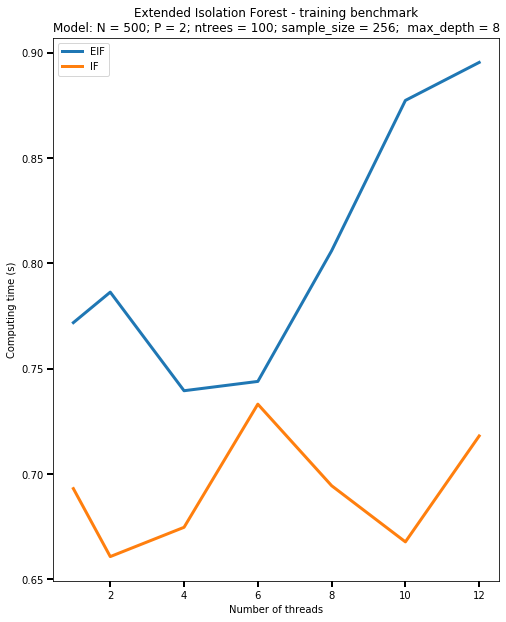

In [6]:
plot_result(eif_time, if_time)

### Small data and high dimension

In [7]:
# Toy data parameters

N = 5000
P = 30
sample_size = 256
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time, if_time = run_benchmark(X)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf5okk9rk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf5okk9rk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf5okk9rk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_pr2ram
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


D:/skola/dip/h2o-3/h2o-py/build/main\h2o\estimators\estimator_base.py:200: RuntimeWarning: Stopping tolerance is ignored for _stopping_rounds=0.
  warnings.warn(mesg["message"], RuntimeWarning)


extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 8.651535272598267s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.4694368839263916s
H2O session _sid_8d20 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcqkawoh5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcqkawoh5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcqkawoh5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_7s6oij
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.12612247467041s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.2928917407989502s
H2O session _sid_bf23 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1fmzesnf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1fmzesnf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1fmzesnf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_u5a566
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.041551113128662s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.6454129219055176s
H2O session _sid_a3c2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp0ycrc8v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp0ycrc8v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp0ycrc8v\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_mll0db
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 6.776376724243164s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.3318634033203125s
H2O session _sid_b6ce closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5a5_3759
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5a5_3759\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5a5_3759\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_ho5llb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.08762788772583s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.640223741531372s
H2O session _sid_a126 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1m_ftf4v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1m_ftf4v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1m_ftf4v\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_wci97m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.378772974014282s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.5121514797210693s
H2O session _sid_a6b5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppry9j5aq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppry9j5aq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppry9j5aq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_v2fe5f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.09918475151062s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.5044453144073486s
H2O session _sid_9bc6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgakqr8b8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgakqr8b8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgakqr8b8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_ceveu9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 6.82907772064209s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.544198751449585s
H2O session _sid_92e5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5i3gzktt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5i3gzktt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5i3gzktt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_8f2dsp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.841102838516235s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.1680152416229248s
H2O session _sid_bce0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpphzo5x8y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpphzo5x8y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpphzo5x8y\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_vn5xup
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 6.891006946563721s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.6294174194335938s
H2O session _sid_9e65 closed.
EIF 7.272235870361328s
IF 1.4738056898117065s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjqfxo5lf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjqfxo5lf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjqfxo5lf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_ha6tn8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 6.95777440071106s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.605391502380371s
H2O session _sid_80c9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4sydif76
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4sydif76\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4sydif76\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_kl0h5g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 17.53083062171936s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 3.1712646484375s
H2O session _sid_874b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptb0go9b4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptb0go9b4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptb0go9b4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_seev64
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.57744026184082s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.30961012840271s
H2O session _sid_91d2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_71l0ztv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_71l0ztv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_71l0ztv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_kuc9c3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 13.763948202133179s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.3242409229278564s
H2O session _sid_8027 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc9kzxpo4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc9kzxpo4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc9kzxpo4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_z32l9g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.023503065109253s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.6979584693908691s
H2O session _sid_a4f0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgdw4fzvv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgdw4fzvv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgdw4fzvv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_hgpume
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.56396222114563s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.4112434387207031s
H2O session _sid_8486 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuzbsijgp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuzbsijgp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuzbsijgp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_n55b8j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.0200090408325195s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.5783052444458008s
H2O session _sid_835a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjdibd7r6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjdibd7r6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjdibd7r6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_swkp5a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.017965316772461s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.6672790050506592s
H2O session _sid_a55c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6sumciv1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6sumciv1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6sumciv1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_jh0fqd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 9.938052415847778s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.3989341259002686s
H2O session _sid_9262 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6ipdus97
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6ipdus97\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6ipdus97\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_w50s6k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 16.014514684677124s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.093109130859375s
H2O session _sid_b1f6 closed.
EIF 10.04080002307892s
IF 1.6257336616516114s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmtzt5dsc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmtzt5dsc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmtzt5dsc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_6stuu6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 6.729554176330566s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.1180264949798584s
H2O session _sid_83f3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuxalkdfh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuxalkdfh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuxalkdfh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_16yjlb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.826826810836792s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.1085987091064453s
H2O session _sid_bb0e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkwr025ct
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkwr025ct\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkwr025ct\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_fgwck6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 12.55247974395752s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.4325518608093262s
H2O session _sid_a596 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp999qg9uu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp999qg9uu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp999qg9uu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_5e6cdw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.031426906585693s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.3116538524627686s
H2O session _sid_b9e3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp56a57cbe
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp56a57cbe\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp56a57cbe\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_tj917v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.997446537017822s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.3040475845336914s
H2O session _sid_ae4c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe02b4tgo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe02b4tgo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe02b4tgo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_vz01bw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 6.529472827911377s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.470038652420044s
H2O session _sid_81b2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpagshwhdo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpagshwhdo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpagshwhdo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_l3kg53
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.420263290405273s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.0867090225219727s
H2O session _sid_a3f5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphiyo05uo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphiyo05uo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphiyo05uo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_l0a7z8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.58816385269165s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.0722863674163818s
H2O session _sid_b323 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp56sffn3y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp56sffn3y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp56sffn3y\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_s325pj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 6.671006441116333s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.4354581832885742s
H2O session _sid_b9e5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_4xhrzqm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_4xhrzqm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_4xhrzqm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_bx1m5p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.509083986282349s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.226076602935791s
H2O session _sid_9156 closed.
EIF 7.785572457313537s
IF 1.2565447330474853s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpytynddxy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpytynddxy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpytynddxy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_sio384
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 12.909099340438843s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.1566922664642334s
H2O session _sid_8f1a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph8gontlf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph8gontlf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph8gontlf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_3pwz4q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 6.70885157585144s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.3028948307037354s
H2O session _sid_905d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpze79lxij
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpze79lxij\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpze79lxij\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_2oxmth
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.798092365264893s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.139397144317627s
H2O session _sid_8ecb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv8d3kbl6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv8d3kbl6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv8d3kbl6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_wgzj4r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.941105365753174s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.2670423984527588s
H2O session _sid_a84b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg973l6xr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg973l6xr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg973l6xr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_9c9cj3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.534478664398193s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.3248295783996582s
H2O session _sid_bbae closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcsb2e86m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcsb2e86m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcsb2e86m\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_8k16ng
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.019023418426514s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.462519884109497s
H2O session _sid_8afd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe8j983n8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe8j983n8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe8j983n8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_3l974o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 11.902780771255493s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.3151195049285889s
H2O session _sid_a2ee closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb0chplnq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb0chplnq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb0chplnq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_lufmo4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 11.944576025009155s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.1936557292938232s
H2O session _sid_81bc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_8vqb544
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_8vqb544\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_8vqb544\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_iyb8pq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.304729461669922s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.3167085647583008s
H2O session _sid_b6be closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4551p00s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4551p00s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4551p00s\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_5gxom4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.2313315868377686s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.1194016933441162s
H2O session _sid_9042 closed.
EIF 8.82940685749054s
IF 1.259826159477234s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp1xr_rj2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp1xr_rj2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp1xr_rj2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_ezigsk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 6.773526906967163s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.1176128387451172s
H2O session _sid_ab9d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbm__n71n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbm__n71n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbm__n71n\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_175dki
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 14.528913259506226s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.789259672164917s
H2O session _sid_8893 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb8l8knhy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb8l8knhy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb8l8knhy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_jt7ycd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.570522308349609s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.1570918560028076s
H2O session _sid_b9f6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg1x4v8zw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg1x4v8zw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg1x4v8zw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_ylhnnu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 6.683077573776245s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.0866069793701172s
H2O session _sid_9da4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzkq9ksou
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzkq9ksou\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzkq9ksou\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_d12ss3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 6.998451232910156s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.4063501358032227s
H2O session _sid_af89 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsletqfoh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsletqfoh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsletqfoh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_zg48la
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.6033854484558105s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.4306085109710693s
H2O session _sid_b5c2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvx3w5hr5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvx3w5hr5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvx3w5hr5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_5mnhvx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.348682165145874s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.1395816802978516s
H2O session _sid_94a7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpobu9oavf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpobu9oavf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpobu9oavf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_z6s5et
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 6.756124496459961s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.1368603706359863s
H2O session _sid_bf2b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbldidetm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbldidetm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbldidetm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_nup9nl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 10.954412460327148s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.1365163326263428s
H2O session _sid_a9b0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprpryzrwr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprpryzrwr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprpryzrwr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_hamaee
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.511333227157593s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.4131927490234375s
H2O session _sid_907a closed.
EIF 8.272842907905579s
IF 1.281368112564087s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp3ys63tu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp3ys63tu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp3ys63tu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_fyc1u9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.619378566741943s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.381676197052002s
H2O session _sid_b33a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcfokbrza
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcfokbrza\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcfokbrza\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_qiuzlk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.804562330245972s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.3926465511322021s
H2O session _sid_8e8b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7xk9p57e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7xk9p57e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7xk9p57e\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_n3mrrl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.535725116729736s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.3631157875061035s
H2O session _sid_b058 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5o4ei2ot
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5o4ei2ot\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5o4ei2ot\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_pk2y8w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.426381349563599s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.3609654903411865s
H2O session _sid_afb5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi6gh37w4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi6gh37w4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi6gh37w4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_0m4fyn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 10.620524883270264s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.6422991752624512s
H2O session _sid_957a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp548dvpdn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp548dvpdn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp548dvpdn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_4zbq4f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.40081524848938s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.3610777854919434s
H2O session _sid_8faa closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprcjx0vk7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprcjx0vk7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprcjx0vk7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_k4hba5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.5354273319244385s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.3616747856140137s
H2O session _sid_807b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp89kmpguo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp89kmpguo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp89kmpguo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_62gy0d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 6.949154853820801s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.389836072921753s
H2O session _sid_a597 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfjwvd3jz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfjwvd3jz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfjwvd3jz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_ndbet6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.727159023284912s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.3598041534423828s
H2O session _sid_8256 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8ulama1s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8ulama1s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8ulama1s\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_ruhu8n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 6.7940514087677s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.3593659400939941s
H2O session _sid_b124 closed.
EIF 7.741318011283875s
IF 1.3972461938858032s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpct22_px6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpct22_px6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpct22_px6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_eb6alo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.9370574951171875s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.9291126728057861s
H2O session _sid_8c2a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgmjte14z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgmjte14z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgmjte14z\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_2uiey0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.827172517776489s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.6099705696105957s
H2O session _sid_8c80 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5mwq7l_l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5mwq7l_l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5mwq7l_l\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_ju3mtj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.747936487197876s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.9124844074249268s
H2O session _sid_b54f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0pgtpn7l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0pgtpn7l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0pgtpn7l\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_6t3ltz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.5456342697143555s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.6452295780181885s
H2O session _sid_850a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2iidstyx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2iidstyx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2iidstyx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_4zmz38
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.199083089828491s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 2.2145261764526367s
H2O session _sid_9a36 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_s4ixujq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_s4ixujq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_s4ixujq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_cyfpr8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.5537025928497314s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.9114930629730225s
H2O session _sid_ab93 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpydfsrby5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpydfsrby5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpydfsrby5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_3zocz9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.876352310180664s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.9722652435302734s
H2O session _sid_b146 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpew15nul1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpew15nul1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpew15nul1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_r9x2mx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.808049440383911s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.6266717910766602s
H2O session _sid_b4cd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvms1pnza
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvms1pnza\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvms1pnza\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_l3x055
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.7561585903167725s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.9112484455108643s
H2O session _sid_98e0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptsd47hs9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptsd47hs9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptsd47hs9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_wp4kxp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 7.727052688598633s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 1.6841225624084473s
H2O session _sid_9218 closed.
EIF 7.697819948196411s
IF 1.8417124509811402s
12 - EIF = 7.272235870361328, IF = 1.4738056898117065
10 - EIF = 10.04080002307892, IF = 1.6257336616516114
8 - EIF = 7.785572457313537, IF = 1.2565447330474853
6 - EIF = 8.82940685749054, IF = 1.259826159477234
4 - EIF = 8.272842907905579, IF = 1.281368112564087
2 - EIF = 7.741318011283875, IF = 1.3972461938858032
1 - EIF = 7.697819948196411, IF = 1.8417124509811402


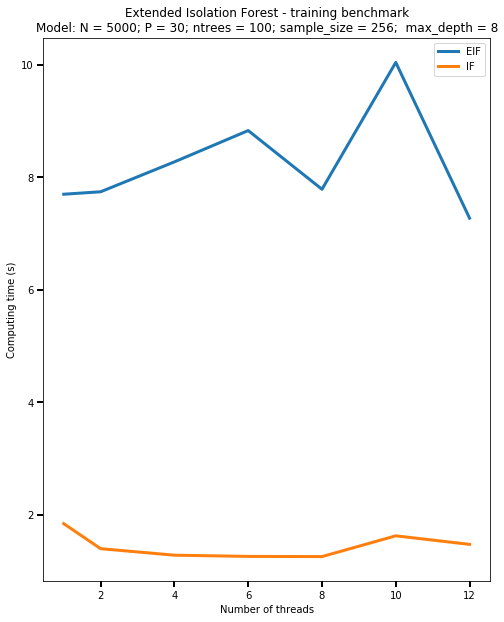

In [8]:
plot_result(eif_time, if_time)

### Big data - small dimension, small sample_size

In [9]:
# Toy data parameters

N = 1_500_000
P = 2
sample_size = 256
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time, if_time = run_benchmark(X)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3nh_nsoy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3nh_nsoy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3nh_nsoy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_zh6vhv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


D:/skola/dip/h2o-3/h2o-py/build/main\h2o\estimators\estimator_base.py:200: RuntimeWarning: Stopping tolerance is ignored for _stopping_rounds=0.
  warnings.warn(mesg["message"], RuntimeWarning)


extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 4.462843418121338s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 12.480517387390137s
H2O session _sid_aef2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwif7nscj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwif7nscj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwif7nscj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_lngsjm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 4.052704334259033s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 13.042620420455933s
H2O session _sid_8058 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqu8bxf5y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqu8bxf5y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqu8bxf5y\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_tr506b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 4.11967396736145s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 13.145487070083618s
H2O session _sid_9752 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7b88ew_6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7b88ew_6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7b88ew_6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_zts7jd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 4.770588159561157s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 13.21015977859497s
H2O session _sid_ab72 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1_mbv034
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1_mbv034\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1_mbv034\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_pcypq2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 4.118752479553223s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 13.489386320114136s
H2O session _sid_9224 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjqu9i8a_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjqu9i8a_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjqu9i8a_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_wqzxek
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 4.810234069824219s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 12.71971869468689s
H2O session _sid_ba32 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzereai1q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzereai1q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzereai1q\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_w7qreb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 4.0661046504974365s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 12.306193590164185s
H2O session _sid_833d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2362azld
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2362azld\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2362azld\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_f4wy9q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.9033448696136475s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 12.513019323348999s
H2O session _sid_8cb7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq1lfewh5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq1lfewh5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq1lfewh5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_e8t527
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.9389116764068604s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 12.161726713180542s
H2O session _sid_bcb4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzungyil6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzungyil6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzungyil6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_7d6yh3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 4.6621644496917725s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 12.200294733047485s
H2O session _sid_b711 closed.
EIF 4.290532207489013s
IF 12.72691240310669s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpalzks2ti
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpalzks2ti\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpalzks2ti\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_qdru6o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.6380975246429443s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 12.256707191467285s
H2O session _sid_a852 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5llwnsxy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5llwnsxy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5llwnsxy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_pmtkgi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 2.781294822692871s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 12.880969762802124s
H2O session _sid_ac5a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwlv91fym
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwlv91fym\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwlv91fym\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_gbtmch
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.7179601192474365s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.49756145477295s
H2O session _sid_acc5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg54mxsln
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg54mxsln\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg54mxsln\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_i89f4c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.6515450477600098s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 12.393945217132568s
H2O session _sid_903b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmlqvmxzo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmlqvmxzo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmlqvmxzo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_zaum7a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.7685093879699707s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.893680334091187s
H2O session _sid_aa9d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1kp9ltrm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1kp9ltrm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1kp9ltrm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_on8tjq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.872274875640869s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 12.775668144226074s
H2O session _sid_a422 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0k84ylbl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0k84ylbl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0k84ylbl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_ddybiq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.6684153079986572s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.895495891571045s
H2O session _sid_994c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz2yy1gqc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz2yy1gqc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz2yy1gqc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_sngicg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 4.315499544143677s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 12.091240167617798s
H2O session _sid_91c3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjc92o8a6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjc92o8a6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjc92o8a6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_wpnvyi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.828277111053467s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 12.32713508605957s
H2O session _sid_903f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp66hmpifz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp66hmpifz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp66hmpifz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_f8i1er
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.779188871383667s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.912914037704468s
H2O session _sid_9f36 closed.
EIF 3.702106261253357s
IF 12.192531728744507s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp8xiijnx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp8xiijnx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp8xiijnx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_1yvoxr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.3260324001312256s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.959127426147461s
H2O session _sid_9f70 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph1hgel6f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph1hgel6f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph1hgel6f\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_k3trm1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.376027822494507s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.895086288452148s
H2O session _sid_a733 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy6601dke
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy6601dke\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy6601dke\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_gek0jd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.6494245529174805s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 12.570303678512573s
H2O session _sid_967e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr30kl2e8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr30kl2e8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr30kl2e8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_w1ie7h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.861248731613159s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.926023244857788s
H2O session _sid_89e8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpohn0rz0e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpohn0rz0e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpohn0rz0e\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_uwlg40
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.7140591144561768s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.849234580993652s
H2O session _sid_bfec closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4txs0ydb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4txs0ydb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4txs0ydb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_bu34ru
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.3286631107330322s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.847609996795654s
H2O session _sid_b10e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu__bdsc8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu__bdsc8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu__bdsc8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_5x6u3p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.3619346618652344s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.91007661819458s
H2O session _sid_9269 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplr4zc43p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplr4zc43p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplr4zc43p\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_bltg96
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.3845067024230957s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.736204385757446s
H2O session _sid_bcae closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyjb8fq9y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyjb8fq9y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyjb8fq9y\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_841prh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.2750871181488037s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.915468215942383s
H2O session _sid_b646 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi115x4op
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi115x4op\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi115x4op\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_v7apiz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.423452854156494s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.870446681976318s
H2O session _sid_b7a7 closed.
EIF 3.4700437068939207s
IF 11.947958111763s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgu_s3cu5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgu_s3cu5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgu_s3cu5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_96lt4z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.1785922050476074s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.844725370407104s
H2O session _sid_8932 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpty8ssdut
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpty8ssdut\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpty8ssdut\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_pulsac
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.2239043712615967s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.93008017539978s
H2O session _sid_99b2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfm8wkapw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfm8wkapw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfm8wkapw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_24mqv1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.1142454147338867s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.693510055541992s
H2O session _sid_b46c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpknge79cu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpknge79cu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpknge79cu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_fkt57d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.732133388519287s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.983421325683594s
H2O session _sid_b511 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplsbz4246
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplsbz4246\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplsbz4246\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_3z7dcf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.232675552368164s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.701103448867798s
H2O session _sid_b7d0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk989vv59
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk989vv59\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk989vv59\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_igzn8l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.2419519424438477s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 12.053857803344727s
H2O session _sid_b037 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpesn_zpad
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpesn_zpad\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpesn_zpad\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_8p10x3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 2.6299376487731934s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 12.081079483032227s
H2O session _sid_a12f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprmvl9cga
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprmvl9cga\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprmvl9cga\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_guq1zw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.875311851501465s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.911033868789673s
H2O session _sid_85d2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4vk4t9d_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4vk4t9d_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4vk4t9d_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_nlf701
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.4761035442352295s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.548020601272583s
H2O session _sid_a3c7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp09rvrbbu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp09rvrbbu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp09rvrbbu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_1s5qij
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 2.488394260406494s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 12.688760757446289s
H2O session _sid_8da4 closed.
EIF 3.2193250179290773s
IF 11.943559288978577s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq46mfbpd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq46mfbpd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq46mfbpd\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_xqff4f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.2652013301849365s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 12.88122034072876s
H2O session _sid_8d8b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_bww0p2l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_bww0p2l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_bww0p2l\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_8golqw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.024181604385376s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 12.843634605407715s
H2O session _sid_9b74 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmtmvtbk9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmtmvtbk9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmtmvtbk9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_mh602h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 2.883554697036743s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 12.79844355583191s
H2O session _sid_841a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfq67xlhx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfq67xlhx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfq67xlhx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_9807e3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 2.9082190990448s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 13.724510192871094s
H2O session _sid_b4e0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt6bk3pz3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt6bk3pz3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt6bk3pz3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_tdqia1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 2.90189790725708s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 12.837284088134766s
H2O session _sid_bd62 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz3hcjrb2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz3hcjrb2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz3hcjrb2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_ydbqko
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.0383236408233643s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 13.239235639572144s
H2O session _sid_b718 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp53w1825n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp53w1825n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp53w1825n\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_zpisgv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.224750518798828s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 12.983160018920898s
H2O session _sid_9deb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpro_gjo93
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpro_gjo93\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpro_gjo93\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_8s65ka
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.2400882244110107s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 13.966691255569458s
H2O session _sid_925d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6diu3b0k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6diu3b0k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6diu3b0k\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_orgdv2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.13381290435791s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 12.915587186813354s
H2O session _sid_9e45 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg4mwpwnp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg4mwpwnp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg4mwpwnp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_1q62c5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.0780539512634277s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 12.960135221481323s
H2O session _sid_953f closed.
EIF 3.0698083877563476s
IF 13.114990210533142s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi606hpa0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi606hpa0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi606hpa0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_lda7ut
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.4839866161346436s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 20.864033222198486s
H2O session _sid_ab59 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwchifmyu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwchifmyu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwchifmyu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_or066c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.202755928039551s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 22.08937907218933s
H2O session _sid_9268 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp22rkvw4o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp22rkvw4o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp22rkvw4o\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_1zao72
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 2.935795307159424s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 21.804280042648315s
H2O session _sid_8a59 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0qypbdoz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0qypbdoz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0qypbdoz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_1xewsi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.611863136291504s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 21.702908277511597s
H2O session _sid_9de5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp03gjnf1_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp03gjnf1_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp03gjnf1_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_5nvnd6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.589730978012085s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 20.754241943359375s
H2O session _sid_960d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphues1zwb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphues1zwb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphues1zwb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_rzqu77
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.0286567211151123s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 20.84098243713379s
H2O session _sid_a26a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0xnddiad
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0xnddiad\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0xnddiad\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_g3lgm3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.2897980213165283s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 21.65969729423523s
H2O session _sid_af4a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_7lh91fz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_7lh91fz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_7lh91fz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_wout5b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.0870285034179688s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 20.450506448745728s
H2O session _sid_be97 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2y75tpa7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2y75tpa7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2y75tpa7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_mq6w0e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.2126305103302s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 20.893608808517456s
H2O session _sid_a7d6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8pcoa9kj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8pcoa9kj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8pcoa9kj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_cox22b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.008211851119995s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 20.70582413673401s
H2O session _sid_8beb closed.
EIF 3.2450457572937013s
IF 21.17654616832733s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2xyzbrwu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2xyzbrwu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2xyzbrwu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_efv8hc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.8931872844696045s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 37.12556600570679s
H2O session _sid_b0e8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzvon2i0y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzvon2i0y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzvon2i0y\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_d2vtmn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.50429105758667s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 37.26560401916504s
H2O session _sid_b19f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_uu685nk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_uu685nk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_uu685nk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_3ure9w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.5564024448394775s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 37.48981761932373s
H2O session _sid_8586 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp75lm4_06
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp75lm4_06\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp75lm4_06\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_ev71jm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.8014397621154785s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 37.402698040008545s
H2O session _sid_b44d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph3vyj59p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph3vyj59p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph3vyj59p\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_1svsqi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.541016101837158s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 37.4335196018219s
H2O session _sid_a0cf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmp12r26d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmp12r26d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmp12r26d\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_esj9eg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.7389297485351562s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 37.55551815032959s
H2O session _sid_a09c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdpm8emdc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdpm8emdc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdpm8emdc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_wboe0i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.544776201248169s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 37.3436439037323s
H2O session _sid_b2a6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmproh5nrb2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmproh5nrb2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmproh5nrb2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_caajbt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.5927329063415527s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 37.367090702056885s
H2O session _sid_a853 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpps3at46p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpps3at46p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpps3at46p\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_116az6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.4737842082977295s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 38.344051361083984s
H2O session _sid_a839 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeudhpu3b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeudhpu3b\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpeudhpu3b\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_4lz88b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 3.701021194458008s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 37.478047132492065s
H2O session _sid_8d61 closed.
EIF 3.6347580909729005s
IF 37.48055565357208s
12 - EIF = 4.290532207489013, IF = 12.72691240310669
10 - EIF = 3.702106261253357, IF = 12.192531728744507
8 - EIF = 3.4700437068939207, IF = 11.947958111763
6 - EIF = 3.2193250179290773, IF = 11.943559288978577
4 - EIF = 3.0698083877563476, IF = 13.114990210533142
2 - EIF = 3.2450457572937013, IF = 21.17654616832733
1 - EIF = 3.6347580909729005, IF = 37.48055565357208


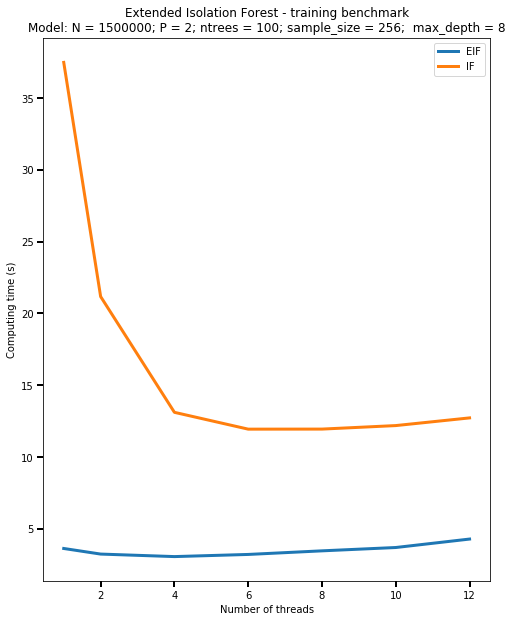

In [10]:
plot_result(eif_time, if_time)

### Big data - high dimension, small sample_size

In [11]:
# Toy data parameters

N = 100_000
P = 30
sample_size = 256
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time, if_time = run_benchmark(X)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvrdbh7rc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvrdbh7rc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvrdbh7rc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_akwt8z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


D:/skola/dip/h2o-3/h2o-py/build/main\h2o\estimators\estimator_base.py:200: RuntimeWarning: Stopping tolerance is ignored for _stopping_rounds=0.
  warnings.warn(mesg["message"], RuntimeWarning)


extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 15.351738452911377s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 3.75989031791687s
H2O session _sid_ac26 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpurtqgbt0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpurtqgbt0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpurtqgbt0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_h59691
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 14.319217443466187s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 3.9605696201324463s
H2O session _sid_a316 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp84mj_e9r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp84mj_e9r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp84mj_e9r\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_7eel6v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 15.085209846496582s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.280660629272461s
H2O session _sid_b1f4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjdv1ql83
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjdv1ql83\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjdv1ql83\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_y69fuz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 16.90671443939209s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.880489110946655s
H2O session _sid_a980 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8i_x1tf5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8i_x1tf5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8i_x1tf5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_5ebzr7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 15.139170169830322s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 3.9401628971099854s
H2O session _sid_9082 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd4i4gb_t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd4i4gb_t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd4i4gb_t\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_d0nk2b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 16.90896511077881s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.90351939201355s
H2O session _sid_bf64 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpejkw0l3r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpejkw0l3r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpejkw0l3r\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_aimbva
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 15.14884090423584s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 5.571681261062622s
H2O session _sid_971d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4x1b9kri
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4x1b9kri\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4x1b9kri\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_fioj5t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 14.788170576095581s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.099591255187988s
H2O session _sid_a0ef closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzmnj5rbc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzmnj5rbc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzmnj5rbc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_ijklsw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 15.860549688339233s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 5.522377014160156s
H2O session _sid_a21a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4jkeue2f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4jkeue2f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4jkeue2f\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_jyjk98
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 14.422136068344116s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 3.9574637413024902s
H2O session _sid_968f closed.
EIF 15.393071269989013s
IF 4.487640523910523s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy_m5c2x0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy_m5c2x0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy_m5c2x0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_t884gb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 14.471750736236572s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.2212042808532715s
H2O session _sid_81e9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnona6nv8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnona6nv8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnona6nv8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_xdlwmo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 20.38844871520996s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 3.8859453201293945s
H2O session _sid_b55d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3q6mm45c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3q6mm45c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3q6mm45c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_57q13s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 13.928764820098877s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.161994457244873s
H2O session _sid_8244 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpecgmki4w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpecgmki4w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpecgmki4w\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_mtwq1o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 14.141786575317383s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.251760959625244s
H2O session _sid_851d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu6up1bbk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu6up1bbk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu6up1bbk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_e5gmrm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 15.766726732254028s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.103978157043457s
H2O session _sid_9227 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpn3knbt9q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpn3knbt9q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpn3knbt9q\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_mddapt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 15.398481130599976s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 5.117302417755127s
H2O session _sid_af12 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbc0f4bj5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbc0f4bj5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbc0f4bj5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_4o8gmt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 13.542681455612183s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.372727632522583s
H2O session _sid_9d90 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpde0w1vgg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpde0w1vgg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpde0w1vgg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_tgqgqr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 15.59876012802124s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.017995595932007s
H2O session _sid_accd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptvad761b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptvad761b\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptvad761b\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_q8upx3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 13.65317416191101s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.07429575920105s
H2O session _sid_8cef closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_jggsesi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_jggsesi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_jggsesi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_u43hb5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 20.359792709350586s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 5.5167317390441895s
H2O session _sid_b5d9 closed.
EIF 15.725036716461181s
IF 4.37239363193512s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphadus96l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphadus96l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphadus96l\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_csdwmt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 14.956866025924683s
isolationforest Model Build progress: |█████████████████████████████████████| 100%
IF Time: 4.981393098831177s
H2O session _sid_84ae closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmj58_tcm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmj58_tcm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmj58_tcm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_bo0noi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 13.87016224861145s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.472498416900635s
H2O session _sid_8cf4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcwczbz0w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcwczbz0w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcwczbz0w\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_r329qb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 14.906156778335571s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 3.8921291828155518s
H2O session _sid_92d1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4m9bi08w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4m9bi08w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4m9bi08w\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_1nmf95
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 15.347290515899658s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.0154407024383545s
H2O session _sid_9772 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcix0azvi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcix0azvi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcix0azvi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_cve939
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 14.791003465652466s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.614291191101074s
H2O session _sid_a9a9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpduqg54xn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpduqg54xn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpduqg54xn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_77wne2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 13.966583490371704s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.569872140884399s
H2O session _sid_a26b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6tqudgfp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6tqudgfp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6tqudgfp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_h6ak0h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 13.942476749420166s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.484761714935303s
H2O session _sid_a9bc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1ywlzvca
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1ywlzvca\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1ywlzvca\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_o0pum1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 14.020184755325317s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.298403024673462s
H2O session _sid_be96 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpth3u3r21
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpth3u3r21\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpth3u3r21\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_tadyfs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 15.080472707748413s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.4756388664245605s
H2O session _sid_af1b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0yg273bw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0yg273bw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0yg273bw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_d5gse6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 14.177245140075684s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.0077760219573975s
H2O session _sid_af88 closed.
EIF 14.50584418773651s
IF 4.381220436096191s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp73t07f4p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp73t07f4p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp73t07f4p\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_43sxsw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 13.640832901000977s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.852811098098755s
H2O session _sid_8d20 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7nr9np9f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7nr9np9f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7nr9np9f\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_lr3sya
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |█████████████████████████████| 100%
EIF Time: 15.025081157684326s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 5.341304302215576s
H2O session _sid_b106 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1jsk1umh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1jsk1umh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1jsk1umh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_7m772i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 14.892227172851562s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 3.8341071605682373s
H2O session _sid_a66a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe1xm6g3t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe1xm6g3t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe1xm6g3t\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_hwza77
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 13.645297288894653s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.6903111934661865s
H2O session _sid_ab0f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmps0tqv1lh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmps0tqv1lh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmps0tqv1lh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_bfbee4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 13.764122247695923s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.064884662628174s
H2O session _sid_b910 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcui52t5k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcui52t5k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcui52t5k\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_krhy0c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 12.715930700302124s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.659060716629028s
H2O session _sid_918f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsec0_eja
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsec0_eja\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsec0_eja\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_pd0b8q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 13.446675300598145s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.70784592628479s
H2O session _sid_ae7b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph_9bisgc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph_9bisgc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph_9bisgc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_z3vil0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 14.719406127929688s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.545658588409424s
H2O session _sid_a4b0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbmcgy9mx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbmcgy9mx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbmcgy9mx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_4m2kvd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 13.978578329086304s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.5921125411987305s
H2O session _sid_8593 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpthwgjamx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpthwgjamx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpthwgjamx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_9iv8ax
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 14.97932481765747s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.193522214889526s
H2O session _sid_9149 closed.
EIF 14.080747604370117s
IF 4.548161840438842s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk_lug2t4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk_lug2t4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk_lug2t4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_n35fu9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 12.335160255432129s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.976902723312378s
H2O session _sid_9821 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpaxpd3cjn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpaxpd3cjn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpaxpd3cjn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_r6na39
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 14.466445446014404s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.750963449478149s
H2O session _sid_88d8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvfghdvuz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvfghdvuz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvfghdvuz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_qplwwv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 13.35987901687622s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.340593576431274s
H2O session _sid_8979 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2rs6p77c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2rs6p77c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2rs6p77c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_1kc72t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 15.264334678649902s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.4602344036102295s
H2O session _sid_8ceb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg5xsnf4d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg5xsnf4d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg5xsnf4d\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_y55w3q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 13.67708969116211s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.299517631530762s
H2O session _sid_afcf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6quyhvc8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6quyhvc8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6quyhvc8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_n4dg3h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 14.698263168334961s
isolationforest Model Build progress: |██████████████████████████████████████| 100%
IF Time: 5.456890344619751s
H2O session _sid_bb83 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9qlrkkrr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9qlrkkrr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9qlrkkrr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_dgo3nz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 13.51135540008545s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.410944700241089s
H2O session _sid_9e61 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8x025n_l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8x025n_l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8x025n_l\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_b0gyw7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 15.204729080200195s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 5.357594728469849s
H2O session _sid_810b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpejc13wko
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpejc13wko\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpejc13wko\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_0vzkqj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 13.056093692779541s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 4.62989616394043s
H2O session _sid_9003 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpon1dwmbd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpon1dwmbd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpon1dwmbd\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_tm8v8e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 13.580382108688354s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 5.13983416557312s
H2O session _sid_9774 closed.
EIF 13.915373253822327s
IF 4.782337188720703s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpix8gh8gk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpix8gh8gk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpix8gh8gk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_ib8u7t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 14.592895030975342s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 7.044398784637451s
H2O session _sid_bef8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpejl5wgos
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpejl5wgos\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpejl5wgos\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_rvvdhk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 13.154517650604248s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 7.098811864852905s
H2O session _sid_9689 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnkqw45ne
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnkqw45ne\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnkqw45ne\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_w7puyx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 14.663153648376465s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 6.9549338817596436s
H2O session _sid_845c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp012pvga3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp012pvga3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp012pvga3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_o37y70
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 13.660108804702759s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 6.506587028503418s
H2O session _sid_bf58 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0bnny47t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0bnny47t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0bnny47t\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_f849kl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 14.375707626342773s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 7.744338274002075s
H2O session _sid_84f6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8a7zxwfm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8a7zxwfm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8a7zxwfm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_28qtuk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 15.552974939346313s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 6.77656102180481s
H2O session _sid_a895 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3cgvkdpc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3cgvkdpc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3cgvkdpc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_2uirtw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 14.516355991363525s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 6.930442571640015s
H2O session _sid_adba closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxsq49a4_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxsq49a4_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxsq49a4_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_0g8784
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 14.69509243965149s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 6.627366304397583s
H2O session _sid_b241 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqjo5yqz2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqjo5yqz2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqjo5yqz2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_jutq41
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 13.390263557434082s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 6.805433750152588s
H2O session _sid_a855 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpblxhe90r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpblxhe90r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpblxhe90r\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_axyj4v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 14.784433603286743s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 7.117959022521973s
H2O session _sid_92f8 closed.
EIF 14.338550329208374s
IF 6.9606832504272464s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8w7i_7c2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8w7i_7c2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8w7i_7c2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_3l9beo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 16.242970943450928s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.443998098373413s
H2O session _sid_9ad4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu86dic8u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu86dic8u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu86dic8u\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_3zn1dq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 15.658907175064087s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.683185815811157s
H2O session _sid_b084 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_n63e7t3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_n63e7t3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_n63e7t3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_39atml
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 15.368234872817993s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.96890139579773s
H2O session _sid_aff6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9347_3zl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9347_3zl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9347_3zl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_u9j02u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 15.232184886932373s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.621490478515625s
H2O session _sid_8224 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3l8def9c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3l8def9c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3l8def9c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_5j9o0w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 18.566365480422974s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.547091722488403s
H2O session _sid_9823 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl0f71w3n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl0f71w3n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl0f71w3n\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_kxjjm2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 16.047868728637695s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.604537963867188s
H2O session _sid_a102 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppoqryt5h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppoqryt5h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppoqryt5h\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_igocjr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 16.008434057235718s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.673278331756592s
H2O session _sid_ab56 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1mvqhfat
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1mvqhfat\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1mvqhfat\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_0znivv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 15.496672630310059s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.680322885513306s
H2O session _sid_8aef closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbwd8fc3r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbwd8fc3r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbwd8fc3r\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_j74gor
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 16.041748046875s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.43591594696045s
H2O session _sid_8dc4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpujfa16an
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpujfa16an\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpujfa16an\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_yjnzvd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 16.663567066192627s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 11.572949886322021s
H2O session _sid_9a8c closed.
EIF 16.132695388793945s
IF 11.623167252540588s
12 - EIF = 15.393071269989013, IF = 4.487640523910523
10 - EIF = 15.725036716461181, IF = 4.37239363193512
8 - EIF = 14.50584418773651, IF = 4.381220436096191
6 - EIF = 14.080747604370117, IF = 4.548161840438842
4 - EIF = 13.915373253822327, IF = 4.782337188720703
2 - EIF = 14.338550329208374, IF = 6.9606832504272464
1 - EIF = 16.132695388793945, IF = 11.623167252540588


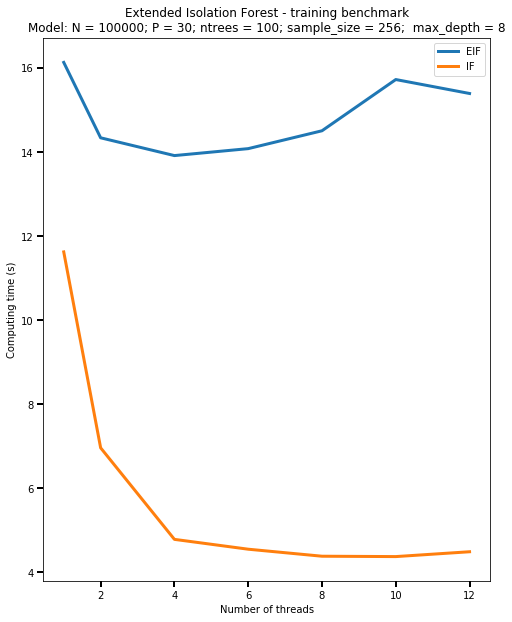

In [12]:
plot_result(eif_time, if_time)

### Big data - small dimension, big sample_size

In [ ]:
# Toy data parameters

N = 1_500_000
P = 2
sample_size = 15_000
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time, if_time = run_benchmark(X)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpytaqf1ks
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpytaqf1ks\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpytaqf1ks\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_7a00xf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


D:/skola/dip/h2o-3/h2o-py/build/main\h2o\estimators\estimator_base.py:200: RuntimeWarning: Stopping tolerance is ignored for _stopping_rounds=0.
  warnings.warn(mesg["message"], RuntimeWarning)


extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 21.739688873291016s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 20.28009843826294s
H2O session _sid_b5e5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa3vyrb4d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa3vyrb4d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa3vyrb4d\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_8qvxfw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 22.770371437072754s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 18.81124496459961s
H2O session _sid_8b7b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq13o1suc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq13o1suc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq13o1suc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_i2t4kq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 21.30909299850464s
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 21.430166721343994s
H2O session _sid_9967 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa6wnyxkv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa6wnyxkv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa6wnyxkv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_potte_x7bli3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
EIF Time: 21.469627857208252s
isolationforest Model Build progress: |

In [ ]:
plot_result(eif_time, if_time)

### Big data - high dimension, big sample_size

In [ ]:
# Toy data parameters

N = 100_000
P = 30
sample_size = 10_000
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time, if_time = run_benchmark(X)

In [ ]:
plot_result(eif_time, if_time)

### Real Credit Card Fraud Detection Data

https://www.kaggle.com/mlg-ulb/creditcardfraud

In [ ]:
# Real data parameters

df = pd.read_csv("creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("creditcard.csv", usecols=cols_to_use)


N = df.shape[0]
P = df.shape[1]
sample_size = int(df.shape[0] * 0.01)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

In [ ]:
eif_time, if_time = run_benchmark(df)

In [ ]:
plot_result(eif_time, if_time)

### Bigger sample_size

In [ ]:
# Real data parameters

df = pd.read_csv("creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("creditcard.csv", usecols=cols_to_use)


N = df.shape[0]
P = df.shape[1]
sample_size = int(df.shape[0] * 0.05)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

In [ ]:
eif_time, if_time = run_benchmark(df)

In [ ]:
plot_result(eif_time, if_time)

## Evaluation Stage

In [ ]:
def run_predict(EIF_model, IF_model, hf_test):
    start = time.time()
    EIF_model.predict(hf_test)
    end = time.time()
    eif_time = end - start
    print(f"EIF Time: {eif_time}s")
    start = time.time()
    IF_model.predict(hf_test)
    end = time.time()
    if_time = end - start
    print(f"IF Time: {if_time}s")    
    return eif_time, if_time


def run_predict_benchmark(train_data, test_data):
    all_times = []
    all_times_num_eif = []
    all_times_num_if = []
    for nthreads in threds:
        times_eif = []
        times_if = []
        h2o.init(nthreads=nthreads)     
        hf_train = h2o.H2OFrame(train_data)    
        hf_test = h2o.H2OFrame(test_data)
        EIF_model = H2OExtendedIsolationForestEstimator(model_id = "extended_isolation_forest.hex",
                                             ntrees = ntrees, seed = seed, sample_size = sample_size, extension_level = P - 1)
        EIF_model.train(training_frame = hf_train)
        IF_model = H2OIsolationForestEstimator(model_id = "isolation_forest.hex",
                                         ntrees = ntrees, seed = seed, sample_size = sample_size, max_depth = max_depth)
        IF_model.train(training_frame = hf_train)
        for i in range(attempt_per_thread):
            eif_time, if_time = run_predict(EIF_model, IF_model, hf_test)
            times_eif.append(eif_time)
            times_if.append(if_time)
        h2o.cluster().shutdown()
        print(f"EIF {np.mean(times_eif)}s")
        print(f"IF {np.mean(times_if)}s")
        all_times_num_eif.append(times_eif)
        all_times_num_if.append(times_if)
        all_times.append(f"thread {nthreads} - EIF {np.mean(times_eif)}s and IF {np.mean(times_if)}s")
        
        eif_means = dict()
        if_means = dict()
        for i, nthreads in enumerate(threds):
            print(f"{nthreads} - EIF = {np.mean(all_times_num_eif[i])}, IF = {np.mean(all_times_num_if[i])}")
            eif_means[nthreads] = np.mean(all_times_num_eif[i])
            if_means[nthreads] = np.mean(all_times_num_if[i])

        return eif_means, if_means


def plot_predict(EIF_means, IF_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in EIF_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_if = {"x":[], "y": [], "label":[]}
    for label, coord in IF_means.items():
        data_if["x"].append(label)
        data_if["y"].append(coord)    

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-', label="EIF", linewidth=3)
    plt.plot(data_if['x'], data_if['y'], '-', label="IF", linewidth=3)
    # plt.grid("off")
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"Extended Isolation Forest - evaluation benchmark\nModel: N = {N_train}; P = {P}; ntrees = {ntrees}; sample_size = {sample_size};  max_depth = {max_depth}\nEvaluation Frame: N = {N}; P = {P}")
    plt.savefig(f"h2o-eval-perf_{sample_size}_{N}_{coord}.png", bbox_inches='tight', pad_inches=.05)
    plt.show()

In [ ]:
# Evaluation stage parameters

N = 100_000
P = 30
N_train = 500_000
sample_size = 10_000
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time, if_time = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(eif_time, if_time)